In [1]:
import anndata
import scanpy as sc
import scgen
import pandas as pd  
import numpy as np

font = {'family' : 'Arial',
        'size'   : 14}

Global seed set to 0
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
train = sc.read("./data/train.h5ad",backup_url='https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk')

/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
print(train)
print(train.obs['condition'].values)

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'
['stimulated', 'stimulated', 'stimulated', 'stimulated', 'stimulated', ..., 'control', 'control', 'control', 'control', 'control']
Length: 16893
Categories (2, object): ['control', 'stimulated']


In [4]:
train[train.obs['condition']=='control'].X

<8007x6998 sparse matrix of type '<class 'numpy.float32'>'
	with 2634770 stored elements in Compressed Sparse Row format>

In [5]:
import pandas as pd  
import numpy as np
def sample_obs(adata,size_n):
    """
    params 
    -------------
    adata
    size_n:the number of rows we will consider in comparison
    output x,y in sparse matrix form
    which is sample1 and sample2 drawn from two specified codition
    """

    x = adata.X
    #print(x.shape)(16893, 6998)
    n_rows=x.shape[0]
    
    df = pd.DataFrame({'x':np.arange(n_rows)})
    #shuffle the data index
    x_sample1=df['x'].sample(frac=1, replace=False).values[:size_n]
    x_sample2=df['x'].sample(frac=1, replace=False).values[:size_n]
    
    return x[x_sample1,:], x[x_sample2,:]

sample_obs(train,train.X.shape[0])


(<16893x6998 sparse matrix of type '<class 'numpy.float32'>'
 	with 5533579 stored elements in Compressed Sparse Row format>,
 <16893x6998 sparse matrix of type '<class 'numpy.float32'>'
 	with 5533579 stored elements in Compressed Sparse Row format>)

In [193]:
def data_prep(adata,conditions=None):
    """
    param
    -----------
    adata
    return_mean: bool variable True if we want to compute mean of sampled data per cell to
    find statistic between mean of data from sample1 and sample2
    output: the sampled data from sample1 and sample2 of type array
    """
    control = adata[adata.obs["condition"] == conditions["x"]]
    stim = adata[adata.obs["condition"] == conditions["y"]]
    
    #fix the number of rows of sampled data as the minimum number of rows between sample1,sample2
    n=np.minimum(control.shape[0],stim.shape[0])
    
    y,_ = sample_obs(control,n)
    x,_ = sample_obs(stim,n)
    
    x=x.toarray()
    y=y.toarray()
    
    return x,y
 
def compute_from_mean(x,y,fn,if_return=False):
    """
    param
    -------
    x,y:data from sample1 and sample2
    fn: the statistic function with input x,y
    print statistic computed with mean of sample 1 and 2
    """ 
    
    x_mean = np.mean(x, axis=0).ravel()
    y_mean = np.mean(y, axis=0).ravel()
    mean = fn(x_mean,y_mean)
    print("statistic computed with mean of sample 1 and 2:",mean)
    if if_return:
        return mean

def compute_from_sample(x,y,fn):
    """
    param
    -----------
    x,y:sampled data from sample1 and sample2 in sparse matric form
    output: the average of statistic computed between each data from sample1 and sample2
    """
#     x=x.toarray()
#     y=y.toarray()
    a=dict.fromkeys(range(x.shape[0]))
    
    for i in range(x.shape[0]):
        a[i]=fn(x[i],y[i])
        
    return np.mean(list(a.values()))


def test(fn,train):
    """
    fn: the function for computing specific statistic to apply 
    print out the test result for statistic between (stim,ctrl) and (ctrl,ctrl)
    
    """
    conditions = {"x": "stimulated", "y": "control"}
    print("mean of computed statistics:",fn(train,conditions))

    conditions = {"x": "control", "y": "control"}
    print("mean of computed statistics:",fn(train,conditions))
    
    return None
 
def dist_based(x,y):
    """
    transpose the data so that we can compute static between genes (columns)
    """
    m=np.minimum(x.shape[0],x.shape[0])
    x=x.T[:,:m]#delete .toarray()
    y=y.T[:,:m]
    return x,y
        
    

In [7]:
from scipy import stats
def calc_pearson(adata, conditions,fn=None):
    """
    param
    ---------
    adata
    condition: dictionary pass to adata to get sample1 and sample2 from specific 'condition'
    fn: function for computing pearson coefficient 
    -----------
    output: the average of pearson coefficient computed between each data from sample1 and sample2
    """
    fn=lambda x,y: stats.pearsonr(x,y).statistic

    x,y=data_prep(adata,conditions)
    
    compute_from_mean(x,y,fn)
    
#     x=x.toarray()
#     y=y.toarray()
    pearson_obs=dict.fromkeys(range(x.shape[0]))
    for i in range(x.shape[0]):
        #use pd
        df = pd.DataFrame({'x':x[i], 'y':y[i]})
        matrix=df.corr(method='pearson').values
        pearson_obs[i] = matrix[0,1]
    
    pr=list(pearson_obs.values())
    
    return np.mean(pr)

test(calc_pearson,train)


statistic computed with mean of sample 1 and 2: 0.8653249069044943
mean of computed statistics: 0.37555144570264
statistic computed with mean of sample 1 and 2: 0.9999999999973818
mean of computed statistics: 0.42847043916316774


In [8]:
from scipy import stats
def calc_mae(adata, conditions,fn=None):
    fn=lambda x,y: np.mean(np.abs(y-x))
    x,y=data_prep(adata,conditions)
    compute_from_mean(x,y,fn)
    return compute_from_sample(x,y,fn)

test(calc_mae,train)

statistic computed with mean of sample 1 and 2: 0.014766272
mean of computed statistics: 0.064424925
statistic computed with mean of sample 1 and 2: 2.5458988e-08
mean of computed statistics: 0.06142647


In [9]:
def calc_euclidean_d(adata, conditions,fn=None):
    fn=lambda x,y: np.linalg.norm(x-y)
    x,y=data_prep(adata,conditions)
    compute_from_mean(x,y,fn) 
    return compute_from_sample(x,y,fn)

test(calc_euclidean_d,train)

statistic computed with mean of sample 1 and 2: 6.5797815
mean of computed statistics: 21.398846
statistic computed with mean of sample 1 and 2: 1.4995142e-05
mean of computed statistics: 19.897516


In [10]:
def calc_r(adata,conditions,fn=None):
    fn=lambda x,y: stats.linregress(x,y)[2]**2
    x,y=data_prep(adata,conditions)
    compute_from_mean(x,y,fn)
    return compute_from_sample(x,y,fn)
test(calc_r,train)

statistic computed with mean of sample 1 and 2: 0.7481821992856497
mean of computed statistics: 0.1525710060806336
statistic computed with mean of sample 1 and 2: 0.9999999999975027
mean of computed statistics: 0.20038285497247008


In [11]:
from scipy.special import rel_entr
from scipy.spatial import distance
from scipy.stats import shapiro,ttest_rel,t,ttest_ind
#distribution based metrics 
#use Jensen-Shannon divergence to replace formula of kl divergence since kl diergence has
#inf result for sparse data 
def average_dist_metric(x,y,fn):
    kl=0
    count_nan=0
    for i in range(x.shape[0]):

        sparse=fn(x[i],y[i])
        if np.isnan(sparse):#nan: caused by division by 0-vector(vec of all 0)
            count_nan+=1   
        else:
            kl+=sparse
    return kl/(x.shape[0]-count_nan)

def calc_kl(adata, conditions):
    x,y=data_prep(adata,conditions)
    x,y=dist_based(x,y)#only for distribution based methods
    fn=lambda x,y: distance.jensenshannon(x,y)
    return average_dist_metric(x,y,fn)

# def calc_kl(adata, conditions):
#     x,y=data_prep(adata,conditions)
#     x,y=dist_based(x,y)#only for distribution based methods
    
#     kl=0
#     count_nan=0
#     for i in range(x.shape[0]):

#         sparse=distance.jensenshannon(x[i],y[i])
#         if np.isnan(sparse):#nan: caused by division by 0-vector(vec of all 0)
#             count_nan+=1   
#         else:
#             kl+=sparse
 

#     return kl/(x.shape[0]-count_nan)

test(calc_kl,train)

/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)


mean of computed statistics: 0.8133531029771389


/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)


mean of computed statistics: 0.8125199976448257


In [13]:

def t_test(adata, conditions):
    x,y=data_prep(adata,conditions)
    x,y=dist_based(x,y)#only for distribution based methods
    fn=lambda x,y: stats.ttest_ind(x,y, equal_var=True)[0]
    return average_dist_metric(x,y,fn)

# def t_test(adata, conditions):
#     x,y=data_prep(adata,conditions)
#     x,y=dist_based(x,y)
    
#     t=0
#     p=0
#     count_nan=0
#     for i in range(x.shape[0]):
        
#         t_stats,p_value=stats.ttest_ind(x[i],y[i], equal_var=True)
    
#         #t_stats,p_value=ttest_rel(x[i], y[i])
#         if np.isnan(t_stats):
#             count_nan+=1
           
#         else:
#             t=t+t_stats
#             p=p+p_value
     
#     print("t-statistic:",t/(x.shape[0]-count_nan))
#     print("p-value",p/(x.shape[0]-count_nan))
   
#     return t/(x.shape[0]-count_nan)

test(t_test,train)

mean of computed statistics: 0.5255426446376334
mean of computed statistics: -8.213753851441806e-09


In [ ]:
from sklearn import metrics

def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

In [ ]:
def mmd(adata, conditions=None):
    x,y=data_prep(adata,conditions)
    x,y=dist_based(x,y)
    
    print("mmd rbf: ",mmd_rbf(x,y))

    return None

conditions = {"x": "stimulated", "y": "control"}
mmd(train,conditions)

conditions = {"x": "control", "y": "control"}
mmd(train,conditions)

In [ ]:
%%time
def calc_wasserstein(adata, conditions,fn=None):
    fn=lambda x,y: stats.wasserstein_distance(x,y)
    x,y=data_prep(adata,conditions)
    x,y=dist_based(x,y)
    return compute_from_sample(x,y,fn)

test(calc_wasserstein,train)   

In [ ]:
# %%time
# def wasserstein(adata, conditions=None):

#     control = adata[adata.obs["condition"] == conditions["x"]]
#     stim = adata[adata.obs["condition"] == conditions["y"]]
#     n=np.minimum(control.shape[1],stim.shape[1])
#     m=np.minimum(control.shape[0],stim.shape[0])

#     y,_ = sample_obs(control,n)
#     x,_ = sample_obs(stim,n)   
    
#     x=x.T[:,:m].toarray()
#     y=y.T[:,:m].toarray()
  
#     d=dict.fromkeys(range(x.shape[1]))
    
#     for i in range(x.shape[0]):
       
#         d[i]=stats.wasserstein_distance(x[i],y[i])
         
#     print(np.mean(list(d.values())))


#     return np.mean(list(d.values()))

# conditions = {"x": "stimulated", "y": "control"}
# wasserstein(train,conditions)

# conditions = {"x": "control", "y": "control"}
# wasserstein(train,conditions)


-0.06459994854032636
Optimization terminated successfully.
         Current function value: 88.919292
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                 y   No. Observations:                   15
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       13
Method:                                      MLE   Df Model:                            1
Date:                           Mon, 17 Apr 2023   Pseudo R-squ.:                  -15.78
Time:                                   20:35:56   Log-Likelihood:                -1333.8
converged:                                  True   LL-Null:                       -79.480
Covariance Type:                       nonrobust   LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
----

/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or c

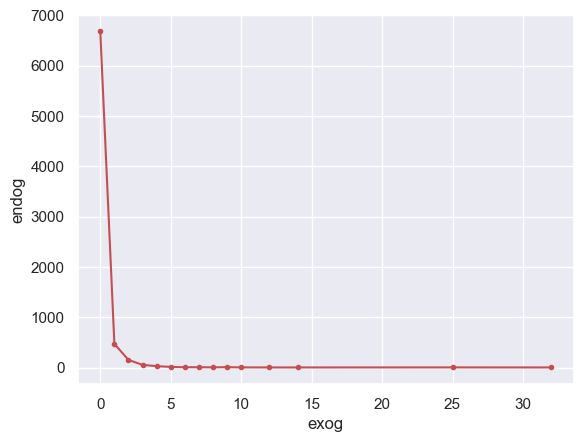

In [115]:
import statsmodels
print(statsmodels.stats.proportion.proportion_effectsize(prop1=0.3, prop2=0.33))
s=np.random.negative_binomial(3,0.25,10000)
X=np.ones_like(s)
#res=sm.ZeroInflatedNegativeBinomial(s,X).fit(start_params=[1,1])
#print(s)
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson,
                                              ZeroInflatedGeneralizedPoisson)
endog=[6679,469,151,52,27,12,5,5,3,6,2,1,1,2,1]
exog=[[1,0],[1,1],[1,2],[1,3],[1,4],[1,5],[1,6],[1,7],[1,8],[1,9],[1,10],[1,12],[1,14],[1,25],[1,32]]


endog=np.array(endog)
exog=np.array(exog)

plt.plot(exog[:,1],endog,'r.-')
plt.xlabel('exog')
plt.ylabel('endog')
plt.savefig('plot.png')

model_zinb = ZeroInflatedNegativeBinomialP(endog, exog)
res_nb = model_zinb.fit(method='bfgs', maxiter=5000, maxfun=5000)
print(res_nb.summary())


In [ ]:
def zero_inflated(adata, conditions):

    x,y=data_prep(adata,conditions)
    x,y=dist_based(x,y)
    
    

[0.05079731 0.05005321 0.03956505 ... 0.03377978 0.05320852 0.0431784 ]


/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/Users/meiq

         Current function value: nan
         Iterations: 1
         Function evaluations: 107
         Gradient evaluations: 107
Optimization terminated successfully.
         Current function value: 0.149431
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                       y   No. Observations:                 8007
Model:             ZeroInflatedPoisson   Df Residuals:                     8006
Method:                            MLE   Df Model:                            0
Date:                 Sun, 23 Apr 2023   Pseudo R-squ.:              -5.933e-05
Time:                         11:37:59   Log-Likelihood:                -1196.5
converged:                        True   LL-Null:                       -1196.4
Covariance Type:             nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z| 

/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/Users/meiq

         Current function value: nan
         Iterations: 1
         Function evaluations: 107
         Gradient evaluations: 107
Optimization terminated successfully.
         Current function value: 0.149431
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                       y   No. Observations:                 8007
Model:             ZeroInflatedPoisson   Df Residuals:                     8006
Method:                            MLE   Df Model:                            0
Date:                 Sun, 23 Apr 2023   Pseudo R-squ.:              -5.933e-05
Time:                         11:38:00   Log-Likelihood:                -1196.5
converged:                        True   LL-Null:                       -1196.4
Covariance Type:             nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z| 

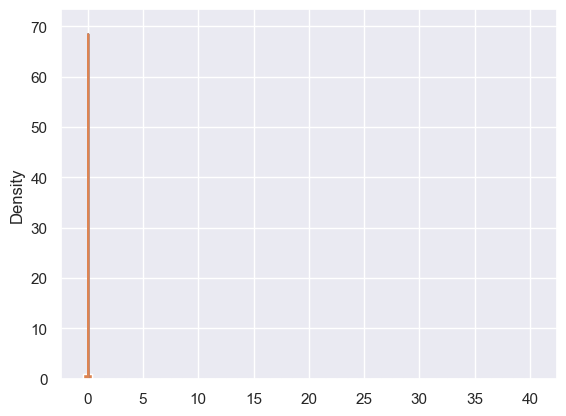

In [169]:
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt,seaborn as sns 
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson,
                                              ZeroInflatedGeneralizedPoisson)

from scipy.optimize import minimize


def zero_inflated(adata, conditions):

    x,y=data_prep(adata,conditions)
    x,y=dist_based(x,y)
    
#     model = sm.ZeroInflatedNegativeBinomialP(y, x).fit()
#     print(model.summary())
  
#     mu=dict.fromkeys(range(x.shape[1]))
#     p=dict.fromkeys(range(x.shape[1]))
#     n=dict.fromkeys(range(x.shape[1]))
    
    x_mean=np.mean(x,axis=0)
    print(x_mean)
    one=np.ones_like(x_mean)
    model_x = ZeroInflatedNegativeBinomialP(x_mean,one).fit()
    #somehow it fails to converge 
    model = sm.ZeroInflatedPoisson(x_mean,one).fit()
    print(model.summary())
    print(model.params)

#     alpha = result.params[0]
#     beta = result.params[1]
#     p_zero = result.params[2]
#     x2 = np.arange(0, max(x[0])+1)
#     pmf = p_zero + (1 - p_zero) * np.exp(-beta) * (beta / (beta + x2 - alpha)) ** alpha
#     plt.hist(x[0], bins=20, density=True, alpha=0.5)

    # Plot the fitted PMF
#     plt.plot(x, pmf, 'r-', lw=2)

#     print(model_x.params)
#     print(model_x.summary())
    mu=np.exp(model_x.params[0])
    p=1/(1+np.exp(model_x.params[0]))*model_x.params[1]
    n=np.exp(model_x.params[0])*p/(1-p)
   
        
#         one=np.ones_like(x[i])
#         model_x = sm.NegativeBinomialP(x[i], one).fit(start_params=[1,1])
#         mu[i]=np.exp(model_x.params[0])
#         p[i]=1/(1+np.exp(model_x.params[0]))*model_x.params[1]
#         n[i]=np.exp(model_x.params[0])*p[i]/(1-p[i])
        
       
         #d[i]=stats.wasserstein_distance(x[i],y[i])
 
    
    x_plot=np.linspace(0,40,41)
    print(x_plot)
    sns.set_theme()
    ax=sns.distplot(x_mean, kde=True,norm_hist=True,label='Real Values')
   
    poisson_prob=model.predict(x_plot)
    print(poisson_prob)
   
    plt.bar(x_plot,poisson_prob)
#     leg=ax.legend()
#     plt.title('zinb')
    


    return None

conditions = {"x": "stimulated", "y": "control"}
zero_inflated(train,conditions)

conditions = {"x": "control", "y": "control"}
zero_inflated(train,conditions)


[0.04436422 0.03696609 0.03530401 ... 0.03600325 0.04579671 0.0343313 ]
Optimization terminated successfully.
         Current function value: 0.149431
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.153529
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                       y   No. Observations:                 8007
Model:             ZeroInflatedPoisson   Df Residuals:                     8006
Method:                            MLE   Df Model:                            0
Date:                 Sun, 23 Apr 2023   Pseudo R-squ.:              -5.933e-05
Time:                         12:04:23   Log-Likelihood:                -1196.5
converged:                        True   LL-Null:                       -1196.4
Covariance Type:        

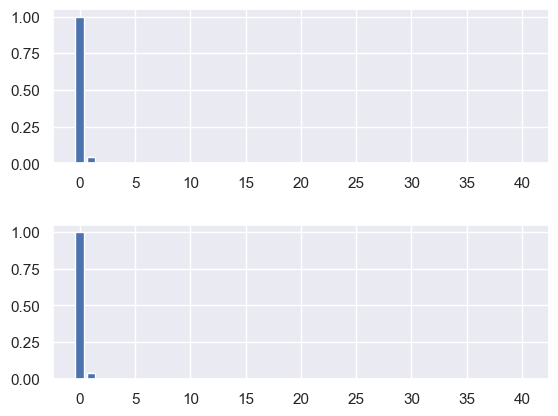

[0.032661   0.03655321 0.04570526 ... 0.04948017 0.04546137 0.03447973]
Optimization terminated successfully.
         Current function value: 0.149431
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.149431
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                       y   No. Observations:                 8007
Model:             ZeroInflatedPoisson   Df Residuals:                     8006
Method:                            MLE   Df Model:                            0
Date:                 Sun, 23 Apr 2023   Pseudo R-squ.:              -5.933e-05
Time:                         12:04:23   Log-Likelihood:                -1196.5
converged:                        True   LL-Null:                       -1196.4
Covariance Type:        

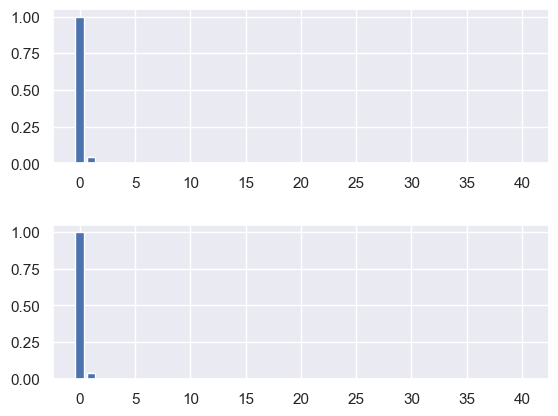

In [180]:
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt,seaborn as sns 
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson,
                                              ZeroInflatedGeneralizedPoisson)


def zero_inflated(adata, conditions):

    x,y=data_prep(adata,conditions)
    x,y=dist_based(x,y)
    
#     model = sm.ZeroInflatedNegativeBinomialP(y, x).fit()
#     print(model.summary())
  
#     mu=dict.fromkeys(range(x.shape[1]))
#     p=dict.fromkeys(range(x.shape[1]))
#     n=dict.fromkeys(range(x.shape[1]))
    
    x_mean=np.mean(x,axis=0)
    y_mean=np.mean(y,axis=0)
    print(x_mean)
    one=np.ones_like(x_mean)
#     model_x = ZeroInflatedNegativeBinomialP(x_mean,one).fit()
    #somehow it fails to converge 
    model = sm.ZeroInflatedPoisson(x_mean,one).fit()
    model2 = sm.ZeroInflatedPoisson(y_mean,one).fit()
    print(model.summary())
    print(model.params)

    
    x_plot=np.linspace(0,40,41)
    k_val = [i for i in range(0, 41)]
    
#     print(x_plot)
#     sns.set_theme()
#     ax=sns.distplot(x_mean, kde=True,norm_hist=True,label='Real Values')
   
    poisson_prob=model.predict(x_plot)
    poisson_prob2=model2.predict(x_plot)
    print("prob 2:",poisson_prob2)
    #print(poisson_prob)
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.bar(k_val, poisson_prob,label="data x")
    ax2.bar(k_val, poisson_prob2,label="data y")
    fig.subplots_adjust(hspace=0.4)

    plt.show()
#     plt.plot(k_val, poisson_prob2)
 


    


    return None

conditions = {"x": "stimulated", "y": "control"}
zero_inflated(train,conditions)

conditions = {"x": "control", "y": "control"}
zero_inflated(train,conditions)


In [ ]:
def sample_obs(adata,size_n):
    """
    params 
    -------------
    adata
    size_n:the number of rows we will consider in comparison
    output x,y in sparse matrix form
    which is sample1 and sample2 drawn from two specified codition
    """

    x = adata.X
    #print(x.shape)(16893, 6998)
    n_rows=x.shape[0]
    
    df = pd.DataFrame({'x':np.arange(n_rows)})
    #shuffle the data index
    x_sample1=df['x'].sample(frac=1, replace=False).values[:size_n]
    x_sample2=df['x'].sample(frac=1, replace=False).values[:size_n]
    
    return x[x_sample1,:], x[x_sample2,:]



In [195]:
import random

def subset(alist, idxs):
    '''
        use idxs to subset alist
        alist: list
        idxs: list
    '''
    sub_list = []
    for idx in idxs:
        sub_list.append(alist[idx])

    return sub_list

def split_list(alist, group_num=3, shuffle=True, retain_left=False):
    '''
        split data into 3 subset and let each subset contains the len(alist)//group number of elements
        shuffle: whether shuffle the splitted data, default: True
        retain_left: if list alist is splited into the number of group_num subset and there is some element remain，
        whether take the remaining elements as a subset
    '''

    index = list(range(len(alist))) 

    
    if shuffle: 
        random.shuffle(index) 
    
    elem_num = len(alist) // group_num 
    sub_lists = {}
    
   
    for idx in range(group_num):
        start, end = idx*elem_num, (idx+1)*elem_num
        sub_lists[str(idx)] = subset(alist, index[start:end])
    
  
    if retain_left and group_num * elem_num != len(index): 
        sub_lists[str(idx+1)] = subset(alist, index[end:])
    
    return sub_lists



def sample_control_control(adata,size_n):
    """
    the sampling for ctrl and ctrl
    split the data into three samples
    shuffle the three samples
    return two data set have maximum between-sample distance
    
    """
    x = adata.X
    n_rows=x.shape[0]
    index_dict=split_list(range(n_rows))# in form {0: [1,2,3],1:[3,44,2...],3:[]}
    sample1=x[index_dict['0'],:size_n]
    sample2=x[index_dict['1'],:size_n]
    sample3=x[index_dict['2'],:size_n]
    
    fn=lambda x,y: np.linalg.norm(x-y)#euclidean distance
    d12=compute_from_mean(sample1,sample2,fn,True)
    d13=compute_from_mean(sample1,sample3,fn,True)
    d23=compute_from_mean(sample2,sample3,fn,True)
    print(d12,d13,d23)
    distance=max(d12,d13,d23)
    if d12==distance:
        return sample1,sample2
    elif d13==distance:
        return sample1,sample3
    elif d23==distance:
        return sample2,sample3
    
sample_control_control(train,train.shape[0])



statistic computed with mean of sample 1 and 2: 0.26898623
statistic computed with mean of sample 1 and 2: 0.29347026
statistic computed with mean of sample 1 and 2: 0.2624903
0.26898623 0.29347026 0.2624903


(<5631x6998 sparse matrix of type '<class 'numpy.float32'>'
 	with 1843747 stored elements in Compressed Sparse Row format>,
 <5631x6998 sparse matrix of type '<class 'numpy.float32'>'
 	with 1847106 stored elements in Compressed Sparse Row format>)